In [48]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pandasgui import show

In [49]:
df = pd.read_csv('../data/sulatto_fulldata2025_version2.csv', delimiter=";", index_col=None)
df_weather = pd.read_csv('../data/tornio_weather.csv')

C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_18344\1475157736.py:1: DtypeWarning: Columns (42) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('../data/sulatto_fulldata2025_version2.csv', delimiter=";", index_col=None)


WEATHER MERGING


In [50]:
 # Step 1: remove the seconds from the steel data
# Steel data: 2023-02-20 20:56:00
# Weather data: year, month, day separately + time : 00:30 (ten minute intervals)

# remove the the seconds (2 numbers + ":")
df['End time'] = df['End time'].str[:-3]

# seems to work! steel data datetime is now e.g. 2023-02-06 01:05

In [51]:
# Step 2: combine all weather time information into a new variable => End time (same as in steel data)
df_weather['End time'] = df_weather['Year'].astype(str) + "-" + \
                         df_weather['Month'].astype(str).str.zfill(2) + "-" + \
                         df_weather['Day'].astype(str).str.zfill(2) + " " + \
                         df_weather['Time [Local time]'].astype(str)

In [52]:
df_weather.head(3)['End time']

0    2023-01-01 00:00
1    2023-01-01 00:10
2    2023-01-01 00:20
Name: End time, dtype: object

In [53]:
# Final step before merging: ROUND THE STEEL DATA minutes into the nearest tens of minutes
# basically we can make a function for pandas to fix this
# the idea: get the minutes from the time
# => round the minutes to nearest 10
# => convert minutes back to string => combine with the original time
def fix_date(row):
    date = row['End time']

    # extract te minutes only from the date
    minutes = int(date[-2:])

    # round the minutes to the nearest ten (by using negative round decimal amount)
    minutes = round(minutes, -1)

    # rebuild the date string
    # date[0:-2] => everything else except the minutes
    result = date[0:-2] + str(minutes).zfill(2)
    return result

# apply the function and check results
df['End time'] = df.apply(fix_date, axis=1)

In [54]:
df['End time'].sample(5)

149821    2023-02-28 14:50
625226    2023-04-25 02:10
547446    2023-04-16 17:20
79277     2023-02-17 18:40
564761    2023-04-19 20:50
Name: End time, dtype: object

In [55]:
# sanity check, how much data we have BEFORE MERGING
# after merging, we should have exactly same amount of data in the end
len(df)

677815

In [56]:
df = df.merge(df_weather, left_on="End time", right_on="End time", how="left")

In [57]:
# sanity check 2 => do we still have exactly same amount of data?
len(df)

677815

In [58]:
df = df.drop(['Year', 'Month', 'Day', 'Time [Local time]',], axis=1)

WEATHER MERGING STOPS HERE

In [59]:
df.columns

Index(['Material Type', 'End time', 'Route', 'Weight', 'Length', 'Thickness',
       'Width', 'Grade', 'Quality Status', 'Seg No', 'Seg from', 'Seg to',
       'CCM.TD. Heat counter Value', 'CCM.TD. Temperature liquidus Value',
       'CCM.TD. Temperature liquidus Dynaphase Value',
       'CCM.TD. TD internals type Value', 'CCM.TD. Slag powder Value',
       'CCM.TD. Stopper Type Value', 'CCM.TD. Steel weight in tundish Value',
       'CCM.TD. Tundish inflow Value', 'CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Stopper pos chg max segment Value',
       'CCM.TD. Stopper position chg 10 s Value',
       'CCM.TD. Stopper position slab chg Value', 'CCM.TD. Superheat Value',
       'CCM.TD. Temperature tundish Value', 'CCM.SEN. SEN Type Value',
       'CCM.SEN. Immersion depth Value', 'CCM.MD. Level average Value',
       'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',


In [60]:
fixables = ["Length", 
            "Thickness",
            'CCM.TD. Steel weight in tundish Value',
            'CCM.TD. Tundish inflow Value', 'CCM.TD. Stopper Last Position Value',
            'CCM.TD. Stopper position max Value',
            'CCM.TD. Stopper position min Value',
            'CCM.TD. Stopper pos chg max segment Value',
            'CCM.TD. Stopper position chg 10 s Value',
            'CCM.TD. Stopper position slab chg Value', 
            'CCM.MD. Level average Value',
            'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
            'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value',
            'CCM.MIX. Concentration factor Value',
            'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value'
            ]

# brute force and change datatype for each of thecolumns
for column_name in fixables:
    df[column_name] = df[column_name].astype(str).replace(regex=",", value=".")
    df[column_name] = df[column_name].astype(float)

We could maybe use Thickness * Length * Width to calculate Volume of slabs, to reduce the amount of columns.

In [61]:
df['Width'] = df['Width'].astype(float) / 1000
df['Thickness'] = df['Thickness'].astype(float) / 1000

df['Slab_volume^m3'] = df['Width'].astype(float) * df['Length'].astype(float) * df['Thickness'].astype(float)
df['Slab_volume^m3'] = df['Slab_volume^m3'].round(2)

DROPS

In [62]:
droppables = ['Material Type', 'Route', 'Seg from', 'Seg to', 'CCM.TD. TD internals type Value', 'Width', 'Thickness', 'Length']
df = df.drop(droppables, axis=1)

 Before we filter only one cast/heat/slab (whatever the level), we have to process and combine the cast/heat/slab -numbers

In [63]:
df['CastNo'].unique()

array([100., 101., 102., 103., 104., 105., 106., 107., 108., 109., 110.,
       111., 112., 113., 114., 115., 116., 117., 118., 119., 120., 121.,
       122., 123., 124., 125., 126., 127., 128., 129., 130., 131., 132.,
       133., 134., 135., 136., 137., 138., 139., 140., 141., 142., 143.,
       144., 145., 146., 147., 148., 149., 150., 151., 152., 153., 154.,
       155., 156., 157., 158., 159., 160., 161., 162., 163., 164., 165.,
       166., 167., 168., 169., 170., 171., 172., 173., 174., 175., 176.,
       177., 178., 179., 180., 181., 182., 183., 184., 185., 186., 187.,
       188., 189., 190., 191., 192., 193., 194., 195., 196., 197., 198.,
       199., 200., 201., 202., 203., 204., 205., 206., 207., 208., 209.,
       210., 211., 212., 213., 214., 215., 216., 217., 218., 219., 220.,
       221., 222., 223., 224., 225., 226., 227., 228., 229., 230., 231.,
       232., 233., 234., 235., 236., 237., 238., 239., 240., 241., 242.,
       243., 244., 245., 246., 247., 248.,  nan])

In [95]:
#selected_id = 100
df_single = df[df['CastNo'].between(112, 118)]

df_single.head(3)

,End time,Weight,Grade,Quality Status,Seg No,CCM.TD. Heat counter Value,CCM.TD. Temperature liquidus Value,CCM.TD. Temperature liquidus Dynaphase Value,CCM.TD. Slag powder Value,CCM.TD. Stopper Type Value,...,Observation station,Air temperature mean [°C],Dew-point temperature mean [°C],Cloud cover [1/8],Air pressure mean [hPa],Relative humidity mean [%],Precipitation amount mean [mm],Weather description,Horizontal visibility mean [m],Slab_volume^m3
45926,2023-02-12 16:10,25796,720-1,ERROR,1,1.0,1455.0,1459.0,Yes,T1,...,Tornio Torppi,2.4,-0.6,Clear (0/8),999.1,81,0,No significant weather,50000,3.31
45927,2023-02-12 16:10,25796,720-1,ERROR,2,1.0,1455.0,1459.0,Yes,T1,...,Tornio Torppi,2.4,-0.6,Clear (0/8),999.1,81,0,No significant weather,50000,3.31
45928,2023-02-12 16:10,25796,720-1,ERROR,3,1.0,1455.0,1459.0,Yes,T1,...,Tornio Torppi,2.4,-0.6,Clear (0/8),999.1,81,0,No significant weather,50000,3.31


<Axes: xlabel='CCM.TD. Stopper Last Position Value', ylabel='CastNo'>

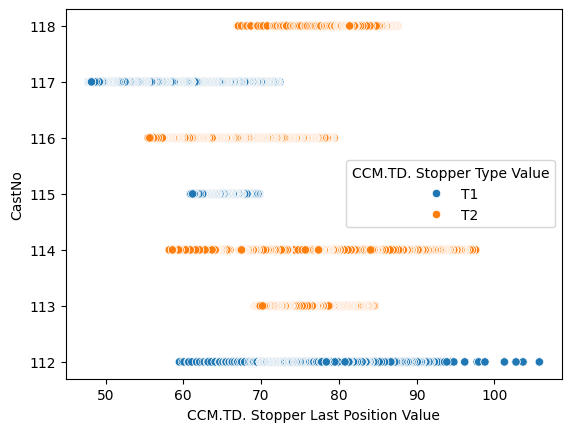

In [65]:
sns.scatterplot(df_single, x='CCM.TD. Stopper Last Position Value', y='CastNo', hue="CCM.TD. Stopper Type Value")

In [66]:
# for easier manipulation in future, we're going to replace the heat numbers with a more simple system
# so instead of 2205, 2170 .... we'll replace them with 1, 2, 3, 4 etc.

unique_heats = list(df_single['HeatNo_in_Cast'].unique())

# this one seems to have 4 heats (cast with id 125)
unique_heats

[np.int64(3843),
 np.int64(4291),
 np.int64(910),
 np.int64(7133),
 np.int64(5733),
 np.int64(2877),
 np.int64(2401),
 np.int64(3836),
 np.int64(3605),
 np.int64(4123),
 np.int64(2429),
 np.int64(5873),
 np.int64(6125),
 np.int64(3696),
 np.int64(3458),
 np.int64(2814),
 np.int64(2212),
 np.int64(3073),
 np.int64(6349),
 np.int64(329),
 np.int64(3486),
 np.int64(4179),
 np.int64(938),
 np.int64(4928),
 np.int64(4613),
 np.int64(7189),
 np.int64(6888),
 np.int64(6111),
 np.int64(1127),
 np.int64(6930),
 np.int64(1575),
 np.int64(3745),
 np.int64(1505),
 np.int64(4130),
 np.int64(6531),
 np.int64(6055),
 np.int64(5887),
 np.int64(4564),
 np.int64(6594),
 np.int64(6986),
 np.int64(4025),
 np.int64(6825),
 np.int64(2842),
 np.int64(2597),
 np.int64(952),
 np.int64(3724),
 np.int64(6440),
 np.int64(3374),
 np.int64(455),
 np.int64(1918)]

In [67]:
# and collect them into a dictionary
replacement_dict = {}

for heat in unique_heats:
    index = unique_heats.index(heat)
    replacement_dict[heat] = index + 1

replacement_dict
df_single['HeatNo_in_Cast'] = df_single['HeatNo_in_Cast'].map(replacement_dict)

C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_18344\3398871969.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single['HeatNo_in_Cast'] = df_single['HeatNo_in_Cast'].map(replacement_dict)


In [68]:
df_single['HeatNo_in_Cast'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50])

In [69]:
df_single['ProcessNo'] = df_single['HeatNo_in_Cast'].astype(str) + \
                         df_single['SlabNo_in_Heat'].astype(str).str.zfill(2) + \
                         df_single['Seg No'].astype(str).str.zfill(2) 


# NOTE TO SELF! SlabNo_in_Heat can be A in some rare cases
# this probably is supposed to be number 10 according to hexadecimal
df_single = df_single.reset_index()
df_single['indexno'] = df_single.index + 1

C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_18344\3985312939.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_single['ProcessNo'] = df_single['HeatNo_in_Cast'].astype(str) + \


In [70]:
df_single

,index,End time,Weight,Grade,Quality Status,Seg No,CCM.TD. Heat counter Value,CCM.TD. Temperature liquidus Value,CCM.TD. Temperature liquidus Dynaphase Value,CCM.TD. Slag powder Value,...,Dew-point temperature mean [°C],Cloud cover [1/8],Air pressure mean [hPa],Relative humidity mean [%],Precipitation amount mean [mm],Weather description,Horizontal visibility mean [m],Slab_volume^m3,ProcessNo,indexno
0,45926,2023-02-12 16:10,25796,720-1,ERROR,1,1.0,1455.0,1459.0,Yes,...,-0.6,Clear (0/8),999.1,81,0,No significant weather,50000,3.31,10101,1
1,45927,2023-02-12 16:10,25796,720-1,ERROR,2,1.0,1455.0,1459.0,Yes,...,-0.6,Clear (0/8),999.1,81,0,No significant weather,50000,3.31,10102,2
2,45928,2023-02-12 16:10,25796,720-1,ERROR,3,1.0,1455.0,1459.0,Yes,...,-0.6,Clear (0/8),999.1,81,0,No significant weather,50000,3.31,10103,3
3,45929,2023-02-12 16:10,25796,720-1,ERROR,4,1.0,1455.0,1459.0,Yes,...,-0.6,Clear (0/8),999.1,81,0,No significant weather,50000,3.31,10104,4
4,45930,2023-02-12 16:10,25796,720-1,ERROR,5,1.0,1455.0,1459.0,Yes,...,-0.6,Clear (0/8),999.1,81,0,No significant weather,50000,3.31,10105,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32535,78461,2023-02-17 14:00,13208,725-1,ERROR,62,3.0,1455.0,1458.0,Yes,...,-1.7,Cloudy (8/8),998.5,98,0,Mist,3523,1.69,500962,32536
32536,78462,2023-02-17 14:00,13208,725-1,ERROR,63,3.0,1455.0,1458.0,Yes,...,-1.7,Cloudy (8/8),998.5,98,0,Mist,3523,1.69,500963,32537
32537,78463,2023-02-17 14:00,13208,725-1,ERROR,64,3.0,1455.0,1458.0,Yes,...,-1.7,Cloudy (8/8),998.5,98,0,Mist,3523,1.69,500964,32538
32538,78464,2023-02-17 14:00,13208,725-1,ERROR,65,3.0,1455.0,1458.0,Yes,...,-1.7,Cloudy (8/8),998.5,98,0,Mist,3523,1.69,500965,32539


In [71]:
# we are going to use multi-line charts + df.melt() to visualize the process better
# see "ricebeefcoffee_revisited.ipynb" from lecture 9 examples on how to work
# with multiline + df.melt()

# list all columns you want to see in the multiline chart
columns_all = [
       'Length', 'Thickness', 'Width', 'Seg No',
       'CCM.TD. Heat counter Value',
       'CCM.TD. Temperature liquidus Value',
       'CCM.TD. Temperature liquidus Dynaphase Value',
       'CCM.TD. Steel weight in tundish Value',
       'CCM.TD. Tundish inflow Value', 'CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Stopper pos chg max segment Value',
       'CCM.TD. Stopper position chg 10 s Value',
       'CCM.TD. Stopper position slab chg Value', 'CCM.TD. Superheat Value',
       'CCM.TD. Temperature tundish Value', 
       'CCM.SEN. Immersion depth Value', 'CCM.MD. Level average Value',
       'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
       'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value',
       'CCM.MD. Mold width Value', 'CCM.MIX. Concentration factor Value',
       'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value',
       'CCM.SLAB. Slab counter heat Value',
       'CCM.SLAB. Slab counter sequence Value']

# here we make more specific set of columns for easier visualization

# IF WE TRY TO VISUALIZE ALL VARIABLES AT ONCE, we can see only straight
# lines because the chart has to zoom out too much

# group of columns with very high values
columns_high = ['Weight']

# group of columns with average value ranges 
columns_middle = ['CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Steel weight in tundish Value',]

# group of columns with small value ranges
columns_low = ['CCM.TD. Tundish inflow Value',
                'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
       'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value', 'CCM.MIX. Concentration factor Value',
       'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value',]


# even less columns in this version with small value ranges
columns_low2 = ['CCM.TD. Tundish inflow Value',
                'CCM.MD. Level std_dev Value', 'CCM.STR. Speed - Mold avg Value', 'CCM.STR. Throughput Value',]

In [72]:
# convert the data from original DataFrame into melt-version (long version)
df_melt_middle = pd.melt(df_single, id_vars=["ProcessNo"], value_vars=columns_middle,
                  var_name="Measurement", value_name="Value")

In [73]:
# convert the data from original DataFrame into melt-version (long version)
df_melt_low = pd.melt(df_single, id_vars=["ProcessNo"], value_vars=columns_low,
                  var_name="Measurement", value_name="Value")

In [74]:
 # convert the data from original DataFrame into melt-version (long version)
df_melt_low2 = pd.melt(df_single, id_vars=["ProcessNo"], value_vars=columns_low2,
                  var_name="Measurement", value_name="Value")

C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_18344\1984794235.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.lineplot(data=df_melt_middle, x="ProcessNo" , y="Value", hue="Measurement", ci=None)


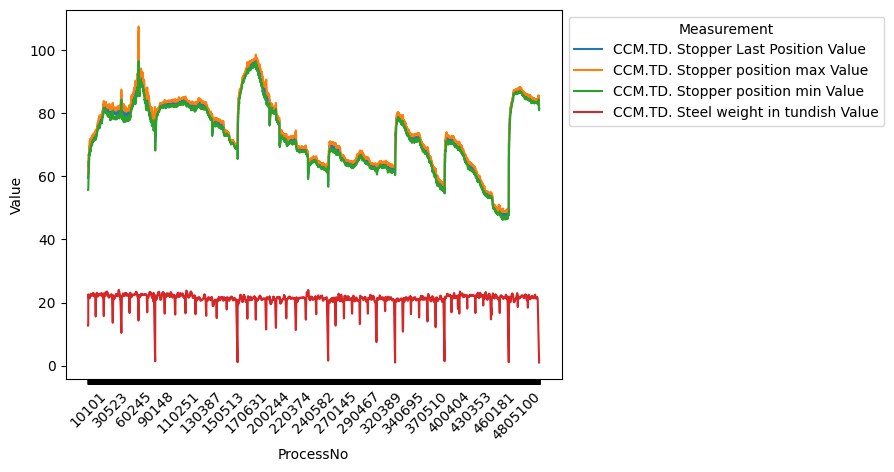

In [75]:
plot = sns.lineplot(data=df_melt_middle, x="ProcessNo" , y="Value", hue="Measurement", ci=None)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1,1))

# reduce the number of x-labels 
n = len(df_single) / 20
[l.set_visible(False) for (i, l) in enumerate(plot.xaxis.get_ticklabels()) if i % n != 0]

# NOTE! using ; in the following line will suppress the Jupyter Notebook 
# default printing behavior of the last line (no idea why this happens!)
plt.xticks(rotation=45);

# you can now use the x-axis rought estimation of the Process No
# if you wish to look the data in more detail of certain trends
# Process No -> example: 20141 => Heat no 2 => slab no 02 => segment no 41

In [97]:
df_melt_middle_new = df_melt_middle[df_melt_middle['ProcessNo'] >= '475545']
df_melt_middle_new2 = df_melt_middle_new[df_melt_middle_new['ProcessNo'] <= '480220']

In [93]:
df_melt_middle_new2['ProcessNo'].unique

<bound method Series.unique of 30350      480101
30351      480102
30352      480103
30353      480104
30354      480105
           ...   
128197    4802112
128198    4802113
128199    4802114
128200    4802115
128201    4802116
Name: ProcessNo, Length: 612, dtype: object>

C:\Users\OMISTAJA\AppData\Local\Temp\ipykernel_18344\2817103212.py:1: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  plot = sns.lineplot(data=df_melt_middle_new2, x="ProcessNo" , y="Value", hue="Measurement", ci=None)


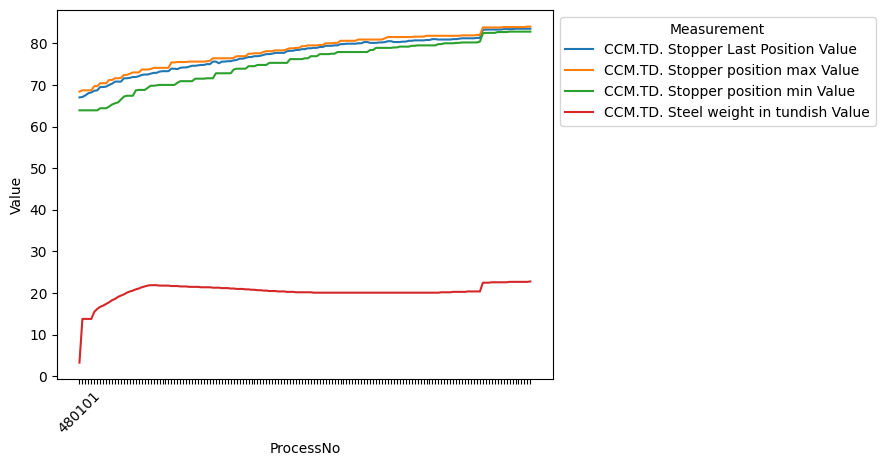

In [98]:
plot = sns.lineplot(data=df_melt_middle_new2, x="ProcessNo" , y="Value", hue="Measurement", ci=None)
sns.move_legend(plot, "upper left", bbox_to_anchor=(1,1))

# reduce the number of x-labels 
n = len(df_single) / 20
[l.set_visible(False) for (i, l) in enumerate(plot.xaxis.get_ticklabels()) if i % n != 0]

# NOTE! using ; in the following line will suppress the Jupyter Notebook 
# default printing behavior of the last line (no idea why this happens!)
plt.xticks(rotation=45);

# you can now use the x-axis rought estimation of the Process No
# if you wish to look the data in more detail of certain trends
# Process No -> example: 20141 => Heat no 2 => slab no 02 => segment no 41

# What the hekk is this??!!?

In [78]:
df_single['Grade'].value_counts()

Grade
720-1    20895
725-8     3273
725-A     1679
725-1     1663
725-U     1572
725-O     1571
720-B      679
725-2      633
720-A      575
Name: count, dtype: int64

In [79]:
df_single.columns

Index(['index', 'End time', 'Weight', 'Grade', 'Quality Status', 'Seg No',
       'CCM.TD. Heat counter Value', 'CCM.TD. Temperature liquidus Value',
       'CCM.TD. Temperature liquidus Dynaphase Value',
       'CCM.TD. Slag powder Value', 'CCM.TD. Stopper Type Value',
       'CCM.TD. Steel weight in tundish Value', 'CCM.TD. Tundish inflow Value',
       'CCM.TD. Stopper Last Position Value',
       'CCM.TD. Stopper position max Value',
       'CCM.TD. Stopper position min Value',
       'CCM.TD. Stopper pos chg max segment Value',
       'CCM.TD. Stopper position chg 10 s Value',
       'CCM.TD. Stopper position slab chg Value', 'CCM.TD. Superheat Value',
       'CCM.TD. Temperature tundish Value', 'CCM.SEN. SEN Type Value',
       'CCM.SEN. Immersion depth Value', 'CCM.MD. Level average Value',
       'CCM.MD. Level change (max-min) Value', 'CCM.MD. Level std_dev Value',
       'CCM.MD. Level std_dev west Value', 'CCM.MD. Level std_dev east Value',
       'CCM.MD. Mold width Value',

In [80]:
df_single['CCM.TD. Stopper Type Value'].value_counts()

CCM.TD. Stopper Type Value
T2    18243
T1    14297
Name: count, dtype: int64